### Importazione librerie e dati

In [1]:
import pandas as pd
import geopandas as gpd
from datetime import time, timedelta, datetime, date 
import contextily as cx
import numpy as np
import json
import numpy as np
from pathlib  import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
from shapely.geometry import Polygon, Point
from fiona.crs import from_epsg
import fiona

#ho cambiato il percorso così da lavorare direttamente nella repo
data_path = Path('.././data/raw')
data_path2 = Path('.././data/external')
files = {'grid':'trentino-grid.geojson',
         'adm_reg':'administrative_regions_Trentino.json',        
         'NOV-DATA':'SET-nov-2013.csv',
         'DEC-DATA':'SET-dec-2013.csv',
         'SET-lines':'line.csv',
         'inquinamento' :  'APPA_inquinamento_aria_Nov_Dec_2013.csv',
         'meteo': 'meteotrentino-weather-station-data.json',
         'comuni':'Com01012013_WGS84.shp',
         'province': 'Prov01012013_WGS84.shp'
        }
# dati inquinamento
df_inquinamento= pd.read_csv(data_path2 / files['inquinamento'] , encoding='latin-1')
#pd.unique(df_inquinamento.Inquinante)

#dati griglia provincia trento
with open(data_path / files['grid']) as f:
    grid_json = json.load(f)

grid = gpd.GeoDataFrame(grid_json['features'])

#consumi sulle linee e dati geografici linee
nomi = ['LINESET', 'time', 'consumi']
df_consumi = pd.read_csv(data_path / files['NOV-DATA'], names = nomi)
df_linee = pd.read_csv(data_path / files['SET-lines'])

#dati sulle regioni amministrative
with open(data_path / files['adm_reg']) as f:
    adm_json = json.load(f)

gdf_adm = gpd.GeoDataFrame(adm_json['items'])

#dati meteo
with open(data_path / files['meteo'] ) as file:
    dati_meteo_json = json.load(file)


dati_comuni = gpd.read_file(data_path2 / files['comuni'] )
dati_province = gpd.read_file(data_path2 / files['province'] )

gdf_comuniTN = dati_comuni[ dati_comuni['COD_PROV'] == 22 ].reset_index(drop=True)
gdf_comuniTN.crs

<Projected CRS: EPSG:32632>
Name: WGS 84 / UTM zone 32N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - N hemisphere - 6°E to 12°E - by country
- bounds: (6.0, 0.0, 12.0, 84.0)
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Aggiusto dati grid

In [2]:
#converto la colonna geometry nel formato Polygon di shapely
grid['geometry'] = grid['geometry'].apply(lambda x:Polygon(x['coordinates'][0]))

#### Questa parte imposta il crs del geoDataFrame ######
# Import specific function 'from_epsg' from fiona module

# Set the GeoDataFrame's coordinate system to WGS84
grid.crs = from_epsg(code = 4326)

/home/gianmarco/anaconda3/envs/DS_2022/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


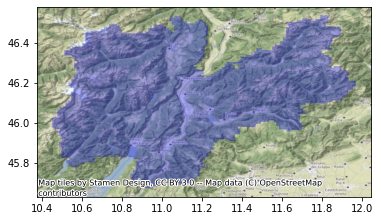

In [3]:
grid['id'] = grid['properties'].apply(lambda x: x['cellId'])
grid.drop(columns=['type', 'properties'], inplace=True) 
axgrid = grid.plot(color='blue', alpha=0.3) #vediamo che la mappa si plotta decentemente
#sovrappongo mappa del trentino
cx.add_basemap(axgrid, crs=grid.crs.to_string() ) 
#per salvare la figura
#plt.savefig("mappaTrentinoBlu.pdf", bbox_inches='tight' , dpi=300) 

### Prima analisi dei consumi elettrici lordi del mese

In [25]:
#poiché la procedura dovrà essere ripetuta, meglio mettere tutto in una funzione 
def genera_mappa_consumi( datiConsumi, df_linee, grid ):
    ''' Restituisce GeoDataFrame per il plot di una mappa in scala di colore a partire dai dati relativi ai consumi.
        Inputs:
            
            datiConsumi:pd.DataFrame che contiene colonna con i codici di linea (LINESET) e i rispettivi consumi
            registrati in un certo giorno e orario.
            
            df_linee: pd.DataFrame che contiene: codici linea, celle per cui passa la linea,
            e nr. di utenze in quella cella.
            
            grid: gpd.GeoDataFrame che contiene le celle in cui è suddiviso il territorio come istanze della classe
                  Polygon (from shapely.geometry)
            
         Returns: 
         
            df_mappa: gpd.GeoDataFrame con il consumo totale su ogni cella del territorio trentino. 
            Totale nel senso di sommato su tutto il periodo del DataFrame datiConsumi .
         '''
    #contiamo le ubicazioni per linea
    df_ubi_per_line = pd.DataFrame(df_linee.groupby('LINESET')['NR_UBICAZIONI'].sum()).reset_index()
    #contiamo i consumi per linea
    df_con_per_line = pd.DataFrame( datiConsumi.groupby('LINESET')['consumi'].sum() ).reset_index()
    #uniamo i due dataframe
    df_consperub = pd.merge(left = df_con_per_line, right = df_ubi_per_line, how = 'outer',on='LINESET' )
    df_consperub = df_consperub.fillna(0)
    #calcolo dei consumi per ubicazione
    df_consperub['cons_per_ubi'] = df_consperub['consumi'] / df_consperub['NR_UBICAZIONI']
    #unisco al dataframe con le linee e le rispettive celle
    df_cons_per_cella = pd.merge(left = df_linee, right = df_consperub[['LINESET','cons_per_ubi']], how = 'outer',on='LINESET')
    df_cons_per_cella['consumo_per_cella'] = df_cons_per_cella['NR_UBICAZIONI']*df_cons_per_cella['cons_per_ubi']
    #sommo i consumi della stessa cella (diverse linee)
    df_cons_per_cella = pd.DataFrame(df_cons_per_cella.groupby('SQUAREID')['consumo_per_cella'].sum() ).reset_index()
    #finalmente unisco tutto al dataframe della mappa che viene ritornato
    df_mappa = pd.merge(left = grid, right = df_cons_per_cella, how = 'left', left_on='id', right_on='SQUAREID')
    df_mappa['consumo_per_cella'] = df_mappa['consumo_per_cella'].fillna(0)
    return df_mappa
    

In [26]:
#questa riga di codice serve per vedere se ci sono linee che passano in celle ma non hanno consumo, perchè evidentemente non hanno ubicazioni 
#spoiler nel dataset di novembre ce ne sono ben 37
#per ora abbandoniamo l'idea di un plot in scala logaritmica
#sum(df_mappa.consumo_per_cella == 0)

# tentativo di fare una scala logaritmica 
#df_mappa['log_consumi'] = np.log(df_mappa['consumo_per_cella'])
#mynorm = mpl.colors.LogNorm(vmin=np.nanmin(df_mappa.iloc[:,5].values) ,vmax=df_mappa['consumo_per_cella'].max() )
#df_mappa.plot('consumo_per_cella', cmap = 'YlOrRd', norm=mynorm)
#df_mappa['consumo_per_cella'].min()


(46.0, 46.15)

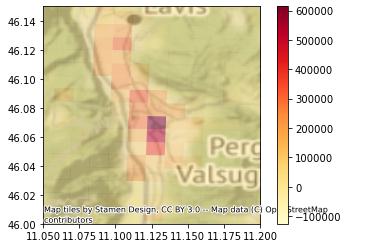

In [27]:
gdf_consumi_lordi = genera_mappa_consumi(df_consumi, df_linee, grid) 
MAX = gdf_consumi_lordi['consumo_per_cella'].max()
MIN = gdf_consumi_lordi['consumo_per_cella'].min()

#gdf_consumi_lordi[ gdf_consumi_lordi['consumo_per_cella']==0 ]['consumo_per_cella'] = 2
#mynorm = mpl.colors.LogNorm(vmin=gdf_consumi_lordi['consumo_per_cella'].min() ,vmax=gdf_consumi_lordi['consumo_per_cella'].max() )
ax_consumi_lordi = gdf_consumi_lordi.plot('consumo_per_cella', cmap='YlOrRd', alpha=0.5) 
cx.add_basemap(ax_consumi_lordi, crs=grid.crs.to_string() )
plt.colorbar(plt.cm.ScalarMappable( norm=ax_consumi_lordi._children[0].norm , cmap='YlOrRd'), ax=ax_consumi_lordi )
ax_consumi_lordi.set_xlim(11.05, 11.20)
ax_consumi_lordi.set_ylim(46.0, 46.15)

### Indagine sulle variazioni di consumi tra giorno e notte

In [28]:
# abbiamo diviso la colonna time in data e ora per riuscire a gestire meglio i dati
#df_consumi[['Date', 'hour']] =df_consumi['time'].str.split(' ', expand=True)
# divido le celle 
df_consumi[['giorno','ora']] = df_consumi.time.str.split(" ",expand=True)
df_consumi.time = df_consumi.time.apply(datetime.fromisoformat)

#NOTA BENE: SI PUÒ RISISTEMARE QUESTA PARTE E LA FUNZIONE GENERAMAPPACONSUMI USANDO IL FORMATO DATETIME DI PANDAS
#df_consumi['datetime'] = pd.to_datetime(df_consumi['time'], format='%Y-%m-%d %H:%M')
# uso magia di stack exchange per dividere il database in due database uno con i consumi diurni e uno con i consumi notturni 
mask = ( pd.to_timedelta(df_consumi['ora'].astype(str).add(':00')).between(pd.Timedelta('08:00:00'), pd.Timedelta('19:00:00')) )
df_consumidiurni = df_consumi[mask]
df_consuminotturni = df_consumi[~mask]
#vogliamo arrivare alla loro differenza (normalizzata sul numero di ore!)

AttributeError: Can only use .str accessor with string values!

In [ ]:
df_mappa_giorno = genera_mappa_consumi( df_consumidiurni, df_linee , grid )
df_mappa_notte = genera_mappa_consumi( df_consuminotturni, df_linee, grid )
#normalizzo i consumi per numero di ore nella giornata
df_mappa_giorno['consumo_per_cella']/=11
df_mappa_notte['consumo_per_cella']/=13
#df_mappa_giorno.head(40) #3762.252046
#df_mappa_notte#df_mappa_generale.head(40) #3762.25204
#df_mappa_generale = plotmap( df_consumi, df_linee, grid)

In [9]:
df_mappa_diff = df_mappa_giorno.copy()
df_mappa_diff['consumo_per_cella'] = -df_mappa_giorno['consumo_per_cella'] + df_mappa_notte['consumo_per_cella']

(45.84, 46.2)

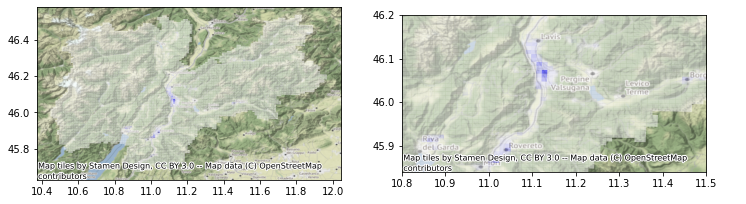

In [10]:
fig, axes = plt.subplots(1,2, figsize=(12,5) ) 
MAX = np.max(np.abs(df_mappa_diff['consumo_per_cella'] )  ) 
norm= plt.Normalize( -MAX, MAX ) 
#bwr: blue white red (in ordine crescente)
df_mappa_diff.plot('consumo_per_cella', cmap='bwr', alpha=0.5, ax=axes[0], norm=norm) 
df_mappa_diff.plot('consumo_per_cella', cmap='bwr', alpha=0.5, ax=axes[1], norm=norm) 
cx.add_basemap(axes[0], crs=grid.crs.to_string() )
cx.add_basemap(axes[1], crs=grid.crs.to_string() )
axes[1].set_xlim(10.8, 11.5) 
axes[1].set_ylim(45.84, 46.2)

In [29]:
# ho aggiunto una colonna che mi enumera i giorni della settimana 
df_consumi["giorno"] = pd.to_datetime(df_consumi["giorno"])
df_consumi["DayOfWeek"] = df_consumi["giorno"].dt.weekday
# ho aggiunto un altra colonna che mi dice se il giorno è un week end o meno
df_consumi["isweekend"] = df_consumi["giorno"].dt.weekday > 4
# creazione di due database filtrando con la condizione sulla colonna DayOfweek molto più comoda di isweekend 
df_consumisettimana = df_consumi[df_consumi.DayOfWeek < 5]
df_consumiweekend = df_consumi[df_consumi.DayOfWeek > 4]
Nset = len(df_consumisettimana.index)
Ntot = len(df_consumi.index)

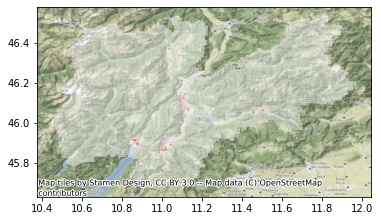

In [30]:
df_mappa_settimana = genera_mappa_consumi( df_consumisettimana, df_linee , grid)
df_mappa_weekend = genera_mappa_consumi( df_consumiweekend, df_linee, grid)
#normalizzo
df_mappa_settimana['consumo_per_cella']/=Nset*144
df_mappa_weekend['consumo_per_cella']/=(Ntot-Nset)*144
# ci sono 144 righe ogni giorno (ogni riga è un quarto d'ora)
df_mappa_diff2 = df_mappa_settimana.copy()
df_mappa_diff2['consumo_per_cella'] = df_mappa_settimana['consumo_per_cella']-df_mappa_weekend['consumo_per_cella']
MAX = np.max(np.abs(df_mappa_diff2['consumo_per_cella'] )  ) 
norm= plt.Normalize( -MAX, MAX )
axs_diff2 = df_mappa_diff2.plot('consumo_per_cella', cmap='bwr', alpha=0.5, norm=norm) 
cx.add_basemap(axs_diff2, crs=grid.crs.to_string() )


# QUI INIZIA UNA PARTE DI NOTEBOOK DA AGGIUSTARE

Nota di giammi: ho scoperto che risulta assai comodo, per gestire gli istanti temporali, usare il formato datetime di pandas, che contiene info precise su : giorno e ora (fino ai millisecondi). La classe è costruita in modo furbo. P.es. se voglio solo l'ora basta _colonna.dt.hour_ oppure voglio sapere che giorno della settimana è uso _colonna.dt.weekday_ . Sarà necessario aggiustare i comandi nella cella seguente.

In [13]:
#from shapely.geometry import Point
#
#gdf_adm['geometry'][0]['coordinates'][0][0][0]
#punto = Point(  gdf_adm['geometry'][0]['coordinates'][0][0][0],gdf_adm['geometry'][0]['coordinates'][0][0][1]     ) 
##gdf_adm['geometry'] = gdf_adm['geometry'].dropna()
##gdf_adm = gdf_adm['geometry'].apply(lambda x:Point(  x['coordinates'][0][0][0],x['coordinates'][0][0][1]     ) )
##gdf_adm.explore()
##print(punto)
#
#gdf_adm.columns
#
##gdf_comuni = gpd.GeoDataFrame( data=[gdf_adm['name'], gdf_adm['geometry']  ], index=gdf_adm.index ) 
#gdf_comuni = gdf_adm[['name','geometry']]
#gdf_comuni
#dgrouped = gdf_comuni.groupby('name')['geometry'].sum()
#gdf_com = pd.DataFrame(dgrouped)
#gdf_com = gdf_com.reset_index()
#gdf_com = gdf_com[gdf_com.geometry != 0]
#print(gdf_com)
## uso magia di stack exchange per dividere il database in due database uno con i consumi diurni e uno con i consumi notturni 
#maskday = (pd.to_timedelta(df_consumi['ora'].astype(str).add(':00'))
#          .between(pd.Timedelta('08:00:00'), pd.Timedelta('19:00:00')))
#maskevening = (pd.to_timedelta(df_consumi['ora'].astype(str).add(':00'))
#          .between(pd.Timedelta('19:00:00'), pd.Timedelta('24:00:00')))
#df_consumiday = df_consumi[maskday]
#df_consumievening = df_consumi[maskevening]
#df_consumiday = df_consumiday[df_consumiday.DayOfWeek < 5]
#df_consumiday
#df_consumievening = df_consumievening[df_consumievening.DayOfWeek < 5]
#df_consumievening
#def calcolaconsumi( datiConsumi, df_linee, grid ):
#    ''' Plotta una mappa in scala di colore a partire dai dati relativi ai consumi (descrizione da completare)'''
#    dgrouped1 = df_linee.groupby('LINESET')['NR_UBICAZIONI'].sum()
#    df_ubi = pd.DataFrame(dgrouped1)
#    ##print(df_ubi)
#    dgrouped = datiConsumi.groupby(['LINESET', 'giorno'])['consumi'].sum()
#    df_con1 = pd.DataFrame(dgrouped)
#    df_con1 = df_con1.reset_index()
#    ##print(df_con1)
#    #df_con1['giorno'] = df_con1['giorno'].apply(date.fromisoformat)
#    df_consperub = pd.merge(left = df_con1, right = df_ubi, how = 'outer',on='LINESET', left_on=None, right_on=None,left_index=False, right_index=False, sort=False, suffixes=('_x', '_y'), copy=True, indicator=False, validate=None  )
#    #print(df_consperub.isna().sum()) avevo provato a contare i nan 
#    # non curiamo i nan perchè causano problemi nel groupby
#    df_consperub['cons_per_ubi'] = df_consperub['consumi'] / df_consperub['NR_UBICAZIONI']
#    ##print(df_consperub)
#    df_cons_per_cella = pd.merge(left = df_linee, right = df_consperub[['LINESET','giorno','cons_per_ubi']], how = 'outer',on='LINESET', left_on=None, right_on=None,left_index=False, right_index=False, sort=False, suffixes=('_x', '_y'), copy=True, indicator=False, validate=None  )
#    df_cons_per_cella['consumo_per_cella'] = df_cons_per_cella['NR_UBICAZIONI']*df_cons_per_cella['cons_per_ubi']
#    ##print(df_cons_per_cella.dtypes)
#    #df_cons_per_cella[['solo_giorno','ora']] = df_cons_per_cella.giorno.str.split(" ",expand=True)
#    #df_cons_per_cella['giorno'] = df_cons_per_cella['giorno'].apply(str())
#    ##print(df_cons_per_cella)
#    dgrouped2 = df_cons_per_cella.groupby(['SQUAREID', 'giorno'])['consumo_per_cella'].sum()
#    df_cons_per_cella = pd.DataFrame(dgrouped2)
#    df_cons_per_cella = df_cons_per_cella.reset_index()
#    ##print(df_cons_per_cella)
#    #df_mappa_ = pd.merge(left = grid, right = df_cons_per_cella, how = 'left', left_on='id', right_on='SQUAREID'  )
#    #df_mappa_['consumo_per_cella'] = df_mappa_['consumo_per_cella'].fillna(0)
#    return df_cons_per_cella
#
#df_datidaclassificaregiorno = calcolaconsumi(df_consumiday , df_linee, grid )
#df_datidaclassificaregiorno
#df_datidaclassificaresera = calcolaconsumi(df_consumievening, df_linee, grid )
#df_datidaclassificaresera
#    

### Riordiniamo i dati meteo

In [31]:
meteo_rawdata = pd.DataFrame(dati_meteo_json['features'])
#convertiamo la colonna geometry nel formato di shapely
meteo_rawdata['geomPoint.geom'] = meteo_rawdata['geomPoint.geom'].apply(lambda x:Point(x['coordinates']) )
meteo_rawdata.rename(columns={'geomPoint.geom':'geometry'} , inplace=True) 
columnlist = meteo_rawdata.columns.tolist()
meteo_rawdata = meteo_rawdata.melt( id_vars=columnlist[:10]) 
#aggiusto la colonna degli orari
meteo_rawdata[['variable', 'rawtime']] = meteo_rawdata['variable'].str.split('.', expand=True) 
meteo_rawdata['datetime'] = pd.to_datetime( meteo_rawdata['date']+meteo_rawdata['rawtime'], format='%Y-%m-%d%H%M' ) 
#e butto quelle vecchie
meteo_rawdata.drop(columns=['rawtime','date'], inplace=True)
#creo un df temporaneo per riorganizzare la colonna con temperature, vento e precipitazioni
temp_df = meteo_rawdata[['station', 'datetime', 'variable', 'value']]

In [32]:
#questo pivot() mi permette di ottenere tre distinte colonne con i valori che mi interessano
temp_df = temp_df.pivot(index=['station', 'datetime'], columns='variable', values='value').reset_index() 
#unisco il df con le tre nuove colonne a quello con i dati raw
meteo_df = pd.merge(left=meteo_rawdata, right=temp_df, how='right', on=['station', 'datetime'] ) 
meteo_df = meteo_df[meteo_df.variable=='temperatures']
#come ultima cosa separo in due la colonna del vento
meteo_df[['winds', 'windDir']] =  meteo_df['winds'].str.split('@', expand=True)
meteo_df.rename(columns={'winds':'windSpeed'}, inplace=True  ) 
meteo_df.drop(columns=[ 'variable', 'value', 'timestamp' ], inplace=True ) 
#butto le colonne ora inutili
meteo_df.reset_index(inplace=True)
meteo_df.drop(columns='index', inplace=True) 

#meteo_df

### Guardiamo come le stazioni meteo sono distribuite sul territorio

(45.9, 46.2)

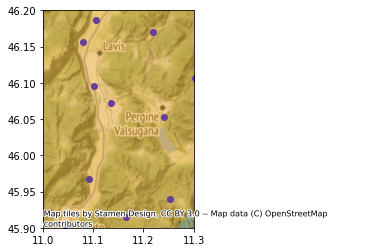

In [33]:
df_mappa_stazioni = meteo_df[['station', 'geometry']]
#df_mappa_stazioni = df_mappa_stazioni.loc[df_mappa_stazioni.astype(str).drop_duplicates().index]
#df_mappa_stazioni.reset_index(inplace=True)
#df_mappa_stazioni.drop(columns='index', inplace=True)
df_mappa_stazioni = gpd.GeoDataFrame(df_mappa_stazioni, crs='EPSG:4326')
df_mappa_stazioni = df_mappa_stazioni.drop_duplicates().reset_index().drop(columns='index')
axmappastazioni = df_mappa_stazioni.plot(color='blue') 
cx.add_basemap(axmappastazioni, crs=df_mappa_stazioni.crs.to_string() ) 
grid.plot(ax=axmappastazioni, color='orange', alpha=0.4) 

axmappastazioni.set_xlim(11.0, 11.3)
axmappastazioni.set_ylim(45.9, 46.2)


## Piano di lavoro per classificazione e regressione

### Obbiettivo: ricavare un dataframe con le seguenti colonne:<br>ZONA, DATA, FASCIAORARIA, PRECIPITAZIONI, TEMPERATURA MEDIA, FLUTTUAZIONITEMPERATURA, VENTO(?), CONSUMOALLORA, CATEGORIA DI CONSUMO

#### Prima si aggiustano i dati meteo così:

1. Divido i dati nelle due fasce orarie di interesse (8-19 e 19-24). 
2. Calcolo le precipitazioni totali in ogni fascia oraria, la temperatura media (volendo, la corrispondente deviazione standard, non lo faccio però perché non mi aspetto sia significativo) e le precipitazioni totali.
7. Posso anche provare a calcolare una media dell'intensità del vento, ma il dato sul vento sembrerebbe inutile. Come tratto la direzione? Sospetto sia irrilevante. Visto che non tutte le stazioni meteo registrano il vento, decido che non considero il vento come feature di interesse, almeno in prima battuta.

#### Poi si divide il territorio trentino in zone (utile per quando si farà analisi su tutto il trentino) al fine di raggrupare i dati dei consumi 

1. Assegnare un set di celle ad ogni stazione meteo, purché i consumi siano significativi in quella zona. Per farlo si procede così (pare la cosa più naturale):

    + Per ogni cella del territorio si calcola la distanza tra il suo centro e ogni stazione meteo.
    + Si associa la cella alla stazione meteo più vicina

2. Creare un dataframe con celle, giorno, fasciaoraria(A-B), consumoorario

3. Raggruppare le celle in base alle zone definite al punto (1) e sommare i loro consumi (groupby)

4. Plottare un'istogramma / fare piccola analisi statistica della distribuzione dei consumi nei vari giorni per individuare buoni range per distinguere categorie di consumo (BASSO/MEDIO/ALTO), es. quartili

5. Creare una nuova colonna CATEGORIA CONSUMO

6. Unire il dataframe ottenuto a quello dei dati meteo



In [34]:
#### Creo funzione per assegnare ad ogni dataframe con dataeora delle ulteriori colonne, che mi dicono: 
#    Il giorno della settimana
#    La fascia oraria ('giorno', 'sera') 

def categorizza_tempo( df ):
    ''' Categorizza la serie temporale di un dataframe. 
        Prende in input un pd.DataFrame che deve avere una colonna 'datetime' nel formato datetime di pandas. Restituisce un dataframe con aggiunte le colonne:
        'TimeRange': 'day' se l'orario è tra le 8:00 (Incluse) e le 19:00 (escluse)
                     'evening' se tra le 19:00 (incluse) e le 24:00(escluse) 
                     'night' negli altri casi
        'isWeekend': bool che identifica se il giorno della settimana è weekend o meno '''
    
    #divido le fasce orarie
    df.loc[(df['datetime'].dt.hour >= 8) & (df['datetime'].dt.hour < 19), 'TimeRange'] = 'day'
    df.loc[(df['datetime'].dt.hour >= 19) & (df['datetime'].dt.hour < 24), 'TimeRange'] = 'evening'
    df['TimeRange'].fillna('night', inplace=True) 
    
    #distinguo giorni della settimana
    df.loc[df['datetime'].dt.weekday >=5, 'isWeekend'] = True
    df['isWeekend'].fillna(False, inplace=True)
    return df
    
def categorizza_consumi( df, consumiColName ):
    '''Categorizza le righe di un pd.DataFrame in base al consumo utilizzando primo e terzo quartile
        detti firstQ e thirdQ rispettivamente.
        Inputs:  

            df: dataframe da categorizzare        
            consumiColName: nome della colonna contenente i consumi
        
        Outputs:
        
        pd.DataFrame uguale a df con l'aggiunta di una colonna 'FASCIA_CONSUMI' che contiene
        0 se df[consumiColName]<firstQ
        1 se firstQ <= df[consumiColName] < thirdQ 
        2 se thirdQ <= df[consumiColName]'''
    
    firstQ = df[ consumiColName ].quantile(q=0.25, interpolation='linear')
    thirdQ = df[ consumiColName ].quantile(q=0.75, interpolation='linear')

    df.loc[(df[consumiColName] >= firstQ) & (df[consumiColName]< thirdQ) , 'FASCIA_CONSUMI'] = 1
    df.loc[(df[consumiColName] >= thirdQ), 'FASCIA_CONSUMI'] = 2
    df['FASCIA_CONSUMI'].fillna(0, inplace=True) 
    
    return df
    

### Elaborazione dati meteo per fascia oraria

In [35]:
meteo_df = categorizza_tempo(meteo_df)
#volendo rimpiazzare i vuoti con dei NaN, ma per ora non serve
#meteo_df.replace(r'^\s*$', np.nan, regex=True, inplace=True)
def adjust_wind( x ):
    if type(x)==str:
        if x=='':
            return float('NaN')
        else:
            return float(x)
    else:
        return float('NaN')

meteo_df[ 'windSpeed' ] = meteo_df[ 'windSpeed' ].apply(adjust_wind)
meteo_df[ 'windDir' ] = meteo_df[ 'windDir' ].apply(adjust_wind)

#creo due pd.Series che contengono dati raggruppati e mediati/sommati come voglio
meanTempGb  = meteo_df.groupby(['station', meteo_df['datetime'].dt.date,'TimeRange']  )['temperatures'].mean() 
sumPrecipGb = meteo_df.groupby(['station', meteo_df['datetime'].dt.date,'TimeRange']  )['precipitations'].sum() 
meanWindsGb = meteo_df.groupby(['station', meteo_df['datetime'].dt.date,'TimeRange']  )['windSpeed'].mean()

# unisco in un dataframe e lo aggiusto
dicttmp = { 'meanTemperature': meanTempGb, 'precipitations': sumPrecipGb, 'meanWinds': meanWindsGb}
df_tmp_gb = pd.DataFrame(dicttmp).reset_index()
df_tmp_gb.rename(columns={'datetime':'date'} , inplace=True) 



#voglio unirlo con i dati di geometry, e altri dati giornalieri non usati nel groupby
df_tmp_tomerge = meteo_df[['station', 'geometry','elevation', 'minTemperature', 'maxTemperature', 'datetime', 'isWeekend', 'TimeRange']]
#il seguente comando genera una warning ma a quanto pare è un falso positivo. 
#serve a tenere solo le date e a buttare le ore
df_tmp_tomerge['date'] =df_tmp_tomerge['datetime'].dt.date
#togliendo datetime ho un df con un sacco di righe uguali, le butto con .drop_duplicates()
df_tmp_tomerge.drop(columns='datetime', inplace=True)
df_tmp_tomerge  = df_tmp_tomerge.loc[df_tmp_tomerge.astype(str).drop_duplicates().index].reset_index()
df_tmp_tomerge.drop(columns='index', inplace=True)
#finalmente unisco i due dataframe
meteo_df = pd.merge(left=df_tmp_tomerge, right=df_tmp_gb, on=['station', 'date', 'TimeRange'])

#aggiusto le colonne relative al vento



/tmp/ipykernel_10936/1101143855.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp_tomerge['date'] =df_tmp_tomerge['datetime'].dt.date
/tmp/ipykernel_10936/1101143855.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp_tomerge.drop(columns='datetime', inplace=True)


### Associazione delle celle di territorio alla più vicina stazione meteo

* Merge tra dataframes di linee e celle
* Per ognuna delle celle attraversate da almeno una linea, calcolo il centro
* Per ogni centro, calcolo tutte le distanze dalle stazioni meteo e prendo il minimo

In [36]:
gdfLineCells = pd.merge(left=grid, right=df_linee, left_on='id', right_on='SQUAREID', how='right').drop(columns='id')
gdfLineCells[['geometry', 'SQUAREID']].drop_duplicates().reset_index().drop(columns='index')
#per calcolare il criordiniamoentroide è tecnicamente opportuno trasformare coordinate sferiche in km
#anche se non dovrebbe fare molta differenza
gdfLineCells.to_crs(epsg=3035, inplace=True)
gdfLineCells['centroid'] = gdfLineCells['geometry'].centroid
df_mappa_stazioni.to_crs(epsg=3035, inplace=True)



### Ad ogni cella del territorio associamo la stazione meteo più vicina

Questo step è necessario per poter associare i consumi dei territori ai rispettivi dati meteo. La programmazione qui è di più basso livello.

In [37]:
#abbasso il livello della programmazione // approccio bruteforce, 
#usando df2.geometry.apply(lambda g: df1.distance(g)), probabilmente a causa di errori di arrotondamento
#la distanza tra alcuni centroidi e alcune stazioni meteo risulta zero.

meteo_stations = list(df_mappa_stazioni['geometry']) 
cell_centroids = list(gdfLineCells['centroid'] )
#creo array che conterrà gli indici corrispondenti alle stazioni meteo più vicine a ogni centroide
nearest_ms_to_cells = np.zeros( (len(cell_centroids),) ) 
for i_cell, pt_cell in enumerate(cell_centroids):
    nearest_index = 0
    nearest_distance = pt_cell.distance(meteo_stations[nearest_index])
    for i_st, pt_st in enumerate(meteo_stations):
        current_distance = pt_cell.distance(pt_st)
        if current_distance <nearest_distance:
            
            nearest_distance=current_distance
            nearest_index = i_st
    
    #fatto il loop sulle stazioni meteo, segno qual è la più vicina
    nearest_ms_to_cells[i_cell] = nearest_index
    stationcodes = df_mappa_stazioni['station'].to_list()

#creo una lista tale che l'i-esimo elemento della lista è il codice della stazione meteo 
#più vicina alla i-esima cella di territorio (nell'ordine in cui appaiono nei dataframe sopra)
codelist = [stationcodes[int(nearest_ms_to_cells[ii])] for ii, p in enumerate(nearest_ms_to_cells)]
gdfLineCells['nearestStation'] = codelist

### Plotto la mappa delle stazioni e regioni in cui ho suddiviso il territorio

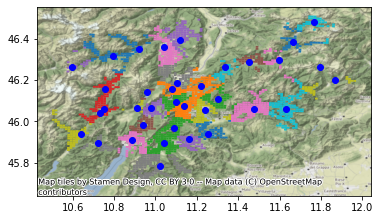

In [38]:
df_mappa_stazioni.to_crs(epsg=4326, inplace=True)
gdfLineCells.to_crs(epsg=4326, inplace=True)
axprova = gdfLineCells.plot('nearestStation', alpha=1)
df_mappa_stazioni.plot(color='blue', ax=axprova) 
cx.add_basemap(axprova, crs=df_mappa_stazioni.crs.to_string() ) 
#per salvare
#plt.savefig('mappaStazioniZone.pdf', dpi=400, bbox_inches='tight') 
#11.13, 46.07

### Creazione di un dataframe con le celle e i rispettivi consumi raggruppati per fascia oraria e tipo di giorno (weekend/infrasett.)

1. Si raggruppano i consumi delle diverse linee per fascia oraria, giorno
2. Conto le celle di ogni linea e poi distribuisco equamente su ciascuna di esse i consumi della linea di ogni giorno e fascia oraria

In [43]:
#sebbene non sia il massimo dell'eleganza, importo di nuovo df_consumi per comodità
#e per evitare conflitti
df_nov = pd.read_csv(data_path / files['NOV-DATA'], names = nomi)
df_dec = pd.read_csv(data_path / files['DEC-DATA'], names = nomi)
df_consumi = pd.concat([df_nov, df_dec])
#prima aggiusto la colonna time convertendola nel formato di pandas
df_consumi['time'] = pd.to_datetime(df_consumi['time'], format='%Y-%m-%d %H:%M')
df_consumi.rename(columns={'time':'datetime'}, inplace=True) 
#suddivido in categorie di tempi
df_consumi = categorizza_tempo( df_consumi ) 
#sommo i consumi fissando linea giorno e fascia oraria
gb = df_consumi.groupby(['LINESET', df_consumi.datetime.dt.date, 'TimeRange', 'isWeekend'])['consumi'].sum()
df_consumi = pd.DataFrame(gb).reset_index()
#contiamo le ubicazioni per linea
df_ubi_per_linea = pd.DataFrame(df_linee.groupby('LINESET')['NR_UBICAZIONI'].sum()).reset_index()
df_consumi = pd.merge(left=df_consumi , right=df_ubi_per_linea, on='LINESET', how='left')
#a questo punto le righe di df_consumi corrispondono solo alle linee che hanno avuto dei consumi cioè le linee
# che appaiono nel dataframe di consumi iniziale 
df_consumi.rename(columns={'NR_UBICAZIONI':'TOT_UBICAZIONI'}, inplace=True ) 
#poiché esistono linee nel df_linee dove non sono registrati consumi in df_consumi,
#questo mi da dei nan che decido di ignorare completamente
df_consumi = pd.merge(left=df_consumi, right=df_linee, on='LINESET', how='outer').dropna()
#per ogni cella sommo i consumi di tutte le linee che vi passano
df_consumi['consumo_della_cella'] = df_consumi['consumi']/df_consumi['TOT_UBICAZIONI']*df_consumi['NR_UBICAZIONI']
df_consumi=df_consumi.groupby([ 'SQUAREID','datetime', 'TimeRange', 'isWeekend'])['consumo_della_cella'].sum().reset_index()
### creo un dataframe con SQUAREID e codici stazioni:
df_suddivisione = gdfLineCells[['SQUAREID', 'nearestStation']].drop_duplicates().reset_index().drop(columns='index')
# unisco dati dei consumi sulle celle con quelli della suddivisione in zone
# in modo da suddividere i consumi in zone
df_consumi = pd.merge(left=df_consumi, right=df_suddivisione, on='SQUAREID', how='left')
# sommo i consumi di ogni zona
df_consumi = df_consumi.groupby(['nearestStation', 'datetime', 'TimeRange', 'isWeekend'])['consumo_della_cella'].sum().reset_index()
#rinomino un po' di colonne per comodità nell'uso di merge
df_consumi.rename(columns={'nearestStation':'station', 'datetime':'date', 'consumo_della_cella':'consumoTerritorio'} , inplace=True)
#segno la durata di ogni fascia oraria così da poter normalizzare il consumo
durataFasce = {'day':11, 'evening':5, 'night':8}
#ad ogni time range associo la sua durata in ore con .map
df_consumi['N_ORE'] = df_consumi['TimeRange'].map(durataFasce)
#finalmente merge tra dati di consumi e meteo
df_meteo_consumi = pd.merge(left=df_consumi, right=meteo_df, on=['station', 'date', 'TimeRange', 'isWeekend'])
#conto le ubicazioni in ogni squareid
df_ubi_squareid = df_linee.groupby('SQUAREID')['NR_UBICAZIONI'].sum().reset_index()
#e unisco il df appena ottenuto con quello contenente SQUAREID e codicistazione
df_ubi_territori = pd.merge(left=df_ubi_squareid, right=df_suddivisione, on='SQUAREID')
#così posso sommare le ubicazioni su ogni territorio
df_ubi_territori = df_ubi_territori.groupby('nearestStation')['NR_UBICAZIONI'].sum().reset_index()
df_ubi_territori.rename(columns={'nearestStation':'station'}, inplace=True) 
#unisco le ubicazioniperterritorio al df con tutti i dati
df_meteo_consumi = pd.merge(left=df_meteo_consumi, right=df_ubi_territori, how='left', on='station')
#in ultimo, aggiungo una colonna per indicare quanto è il consumo/(ora*ubicazione) in quel territorio
df_meteo_consumi['consumoOrarioUbicazione'] = df_meteo_consumi['consumoTerritorio']/(df_meteo_consumi['NR_UBICAZIONI']*df_meteo_consumi['N_ORE'])
#la stazione meteo di trento è T0129 , vedi mappa sopra
dfTrento = df_meteo_consumi[ (df_meteo_consumi['station']=='T0129')
                            & (df_meteo_consumi['isWeekend']==False)  ]                     
dfTrentoZone = df_meteo_consumi[  ((df_meteo_consumi['station']=='T0129') | (df_meteo_consumi['station']=='T0135'))
                            & (df_meteo_consumi['isWeekend']==False)  ]     #  (11.13565 46.07185)(11.13565 46.07185)(11.13565 46.07185)

#### In questa sezione:
* si riordina il database dei dati sull'inquinamento, separando i vari inquinanti in diverse colonne
   e categorizzando in fasce orarie e giorni infrasettimanali/weekend
* si unisce con i dati di meteo e consumi già uniti precedentemente in un unico dataframe

In [44]:
dfInqTrento = df_inquinamento[ (df_inquinamento['Stazione'] =='Parco S. Chiara' ) | (df_inquinamento['Stazione'] ==  'Via Bolzano' )]
#convertiamo in datetime.
#notiamo che le ore vanno da 1 a 24 mentre vorremmo che andassero da 0 a 23.
#decidiamo per ora di convertirle nel formato adeguato semplicemente sottraendo 1.
#per essere precisi si dovrebbe modificare la funzione che categorizza i tempi in fasce orarie
#in modo da far sì che "sera" sia : dalle 18 alle 23 anzichè dalle 19 alle 24
#(idem per "giorno")
dfInqTrento['Ora'] = dfInqTrento['Ora'].apply( lambda x: f"{x-1:02d}:00" ) 
dfInqTrento['datetime'] = pd.to_datetime( dfInqTrento['Data']+ dfInqTrento['Ora'],format='%Y-%m-%d%H:%M' )
dfInqTrento = dfInqTrento.drop(columns=['Data','Ora'])
#separo le colonne di diversi inquinanti riferiti a stazioni diverse
dfInqTrento =  dfInqTrento.pivot(index=[ 'Unità di misura', 'datetime'], columns=['Stazione','Inquinante'], values='Valore').reset_index()
#riduco a un solo livello di nomi colonne
dfInqTrento.columns=[' '.join(col).strip() for col in dfInqTrento.columns.values]
#divido in fasce orarie
dfInqTrento=categorizza_tempo(dfInqTrento)

#noto che alcune misure di inquinanti sono salvate in stringhe (errore quando si applica mean() ) 
#eseguo dunque conversione in float usando .apply. 
#noto anche che in alcune caselle dell'Ossido di carbonio appare la stringa 'n.d.' e la 
#convertiamo in NaN usando la seguente funzione. 
def aggiusta_float(x):
    '''definisco una funzione per trasformare le stringhe in float e, qualora esse siano 'n.d', trasformarle in NaN'''
    if x=='n.d.':
        return float('NaN')
        
    else:
        return float(x)

columns_inquinanti = list(dfInqTrento.columns[2:10])

for c in columns_inquinanti:

    dfInqTrento[c] = dfInqTrento[c].apply(aggiusta_float)
    

#finalmente pronti per fare la media degli inquinanti nelle varie fasce orarie di ogni giorno

dfInqTrento = dfInqTrento.groupby([dfInqTrento['datetime'].dt.date,
                     'Unità di misura', 'TimeRange','isWeekend'])[columns_inquinanti].mean().reset_index()

dfInqTrento.rename(columns={'datetime':'date'}, inplace=True)

#attenzione: necessario .groupby.agg(np.nanmean) perché ogni riga è sdoppiata
#np.nanmean restituisce nan se entrambi gli elementi sono nan, altrimenti restituisce l'unico che non è nan
#cioè per ogni giorno e fascia oraria (es. 1 novembre sera) ci sono due righe e non una:
#una riga contiene solo dati di S.Chiara, l'altra solo di Via Bolzano

dfInqTrento = dfInqTrento.groupby( ['date', 'TimeRange', 'isWeekend']).agg(np.nanmean).reset_index()
#tolgo i weekend
dfInqTrento_infraset = dfInqTrento[ ~dfInqTrento['isWeekend'] ]
#e finalmente unisco con dati di meteo e consumi
dfMeteoInqCons = pd.merge( left=dfInqTrento_infraset, right=dfTrento, on=['TimeRange', 'isWeekend', 'date'])

/tmp/ipykernel_10936/3976181647.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfInqTrento['Ora'] = dfInqTrento['Ora'].apply( lambda x: f"{x-1:02d}:00" )
/tmp/ipykernel_10936/3976181647.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfInqTrento['datetime'] = pd.to_datetime( dfInqTrento['Data']+ dfInqTrento['Ora'],format='%Y-%m-%d%H:%M' )


In [ ]:
#from pandas_profiling import ProfileReport 

#ProfileReport(dfMeteoInqCons[dfMeteoInqCons['TimeRange']=='day'])

### Categorizzazione dei consumi in fasce 'alto', 'medio', 'basso'
* plottiamo istogramma per guardare i consumi, in ogni diversa fascia oraria
* plottiamo quartili e suddividiamo in categorie

Notiamo che l'unità di misura del consumo sono Ampere (sommati). Non è l'idea migliore: occorre moltiplicare per un tempo (10min) e per il voltaggio delle linee elettriche (che non conosciamo). Questo fa sì che i dati differiscono dal consumo energitico espresso in kWh per una costante moltiplicativa.
Poiché il voltaggio delle linee non è dato nell'articolo, manteniamo Ampere come unità di misura dell'energia, anche se si tratta di un abuso di unità di misura. ricordandoci che intendiamo questa cosa. 

/tmp/ipykernel_10936/2263031124.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[(df[consumiColName] >= firstQ) & (df[consumiColName]< thirdQ) , 'FASCIA_CONSUMI'] = 1
/tmp/ipykernel_10936/2263031124.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['FASCIA_CONSUMI'].fillna(0, inplace=True)
/tmp/ipykernel_10936/2263031124.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

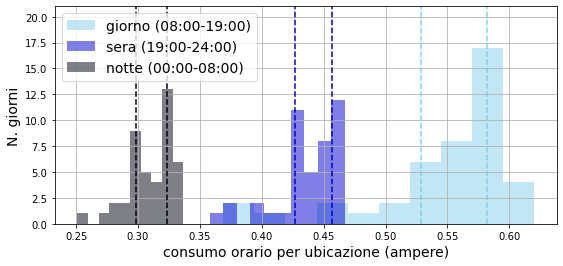

In [45]:
#prima di tutto visualizziamo un po' i nostri dati
dfMeteoInqCons.loc[:,'date'] = pd.to_datetime(dfMeteoInqCons['date']).dt.dayofyear
dfTrentoDay = dfMeteoInqCons[  dfMeteoInqCons['TimeRange'] == 'day' ]
dfTrentoEv = dfMeteoInqCons[ dfMeteoInqCons['TimeRange'] =='evening']
dfTrentoNight = dfMeteoInqCons[ dfMeteoInqCons['TimeRange'] =='night']
dfFasceOrarie = [dfTrentoDay, dfTrentoEv, dfTrentoNight]
fig, axs_hist = plt.subplots(1,1, figsize=(9,4))
fasce = ['giorno (08:00-19:00)', 'sera (19:00-24:00)', 'notte (00:00-08:00)']
colors=['skyblue', 'mediumblue', '#000013']
quartiles = []
ylims = [0,21]
fs = 14
for ii in range(3):
    firstQ = dfFasceOrarie[ii]['consumoOrarioUbicazione'].quantile(q=0.25, interpolation='linear')
    thirdQ = dfFasceOrarie[ii]['consumoOrarioUbicazione'].quantile(q=0.75, interpolation='linear')
    quartiles.append( (firstQ, thirdQ) ) 
    axs_hist.hist(dfFasceOrarie[ii]['consumoOrarioUbicazione'], color=colors[ii], alpha=0.5, label=fasce[ii])
    axs_hist.set_xlabel('consumo orario per ubicazione (ampere)', fontsize=fs)
    axs_hist.set_ylabel('N. giorni', fontsize=fs)
    axs_hist.grid(visible='True')
    axs_hist.legend(fontsize=fs, loc='upper left')
    axs_hist.set_ylim(0,21)
    for jj in range(2):
        axs_hist.plot( quartiles[ii][jj]*np.ones( (2,)), ylims, color=colors[ii] , linestyle='--')
    # e finalmente inseriamo una colonna con la categoria di consumo
    
    dfFasceOrarie[ii] = categorizza_consumi (dfFasceOrarie[ii], 'consumoOrarioUbicazione')

dfMeteoInqCons = pd.concat(dfFasceOrarie)



### Visualizziamo la matrice delle correlazioni come EDA

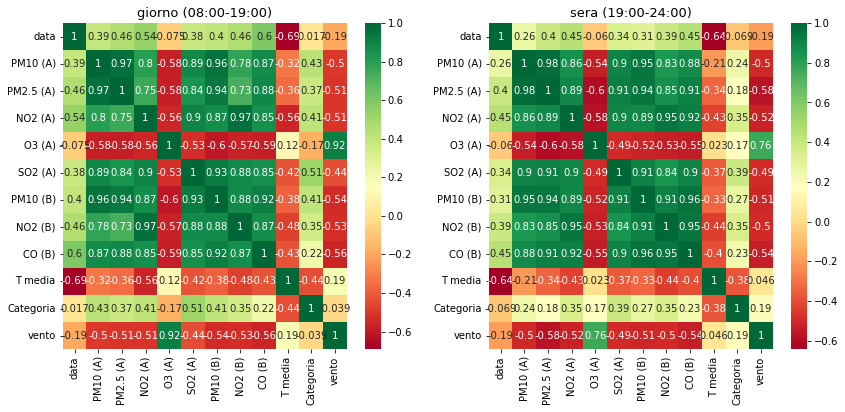

In [46]:
import seaborn as sns
#rinomino le colonne per rendere più leggibile il plot della matrice
dict_nomicolonneita = {"date":"data", "Parco S. Chiara PM10": "PM10 (A)", "Parco S. Chiara PM2.5": "PM2.5 (A)", 
                       "Parco S. Chiara Biossido di Azoto": "NO2 (A)", "Parco S. Chiara Ozono": "O3 (A)",
                       "Parco S. Chiara Biossido Zolfo": "SO2 (A)", "Via Bolzano PM10":"PM10 (B)", 
                       "Via Bolzano PM10":"PM10 (B)", "Via Bolzano Biossido di Azoto":"NO2 (B)",
                       "Via Bolzano Ossido di Carbonio":"CO (B)", "meanTemperature":"T media", "FASCIA_CONSUMI":"Categoria", "meanWinds":"vento"}

figmat, axs_corr_mat = plt.subplots(1,2, figsize=(14,6))

for ii in range(2):
    dfFasceOrarie[ii].rename(columns=dict_nomicolonneita, inplace=True)
    features = ['data',] + list( dfFasceOrarie[ii].columns.values[3:11]) + ['T media',]
    target = list(['Categoria',])
    corr_columns = features + target + ['vento',]
    corr = dfFasceOrarie[ii][corr_columns].corr()
    sns.heatmap(corr, ax=axs_corr_mat[ii], cmap=plt.cm.RdYlGn, annot=True)
    axs_corr_mat[ii].set_title( fasce[ii] , fontsize=13)


In [49]:
#definisco una funzione per aggiungere colonne con dati relativi al giorno successivo
def addNextDay( dfTN , cols2drop): 
    dfTN['dayOfWeek'] = dfTN['date'].apply(datetime.weekday)
    #dataframe temporaneo che contiene dati da shiftare di una riga
    
    dfTN_xp1 = dfTN.copy()
    
    #preparo per join dei dataframes
    #print('DEBUG')
    #print(dfTN_xp1.iloc[0,:] )
    dfTN_xp1 = dfTN_xp1.drop(labels=0, axis=0).reset_index(drop=True)
    dfTN = dfTN.drop(dfTN.tail(1).index).reset_index(drop=True)
    
    #unisco i dataframe
    dfTN = dfTN.join(dfTN_xp1, lsuffix = '_x', rsuffix='_x+1')
    #tolgo righe brutte (x=venerdì, x+1=lunedì, non ci interessano)
    rowsToDrop = dfTN[ ( dfTN['dayOfWeek_x'] == 4 ) & ( dfTN['dayOfWeek_x+1']==0 )  ].index
    rowsToKeep = dfTN[ (( dfTN['dayOfWeek_x'] == 0 ) & ( dfTN['dayOfWeek_x+1']==1 ) )
                               | ( ( dfTN['dayOfWeek_x'] == 2) & ( dfTN['dayOfWeek_x+1']==3 ) )].index
    dfTN.drop( rowsToDrop , axis=0, inplace=True ) 
    #ora il df è pronto per il fit, o quasi (bisogna togliere colonne inutili) 
    
    dfTN.drop(columns = cols2drop , inplace=True)    
    
    return dfTN


dfTrentoZone = df_meteo_consumi[  ((df_meteo_consumi['station']=='T0129') | (df_meteo_consumi['station']=='T0135'))
                            & (df_meteo_consumi['isWeekend']==False)  ] 
dfTrentoZoneDay = dfTrentoZone[ dfTrentoZone['TimeRange'] == 'day' ]
dfTrentoZoneEv = dfTrentoZone[ dfTrentoZone['TimeRange'] == 'evening' ]
dfTrentoZoneDay = categorizza_consumi(dfTrentoZoneDay, 'consumoOrarioUbicazione')
dfTrentoZoneEv = categorizza_consumi(dfTrentoZoneEv, 'consumoOrarioUbicazione')

columns_to_drop2 = ['date_x', 'date_x+1' , 'TimeRange_x', 'isWeekend_x','dayOfWeek_x',
                      'TimeRange_x+1', 'isWeekend_x+1', 'dayOfWeek_x+1']

dfTrentoZoneDayA = addNextDay(dfTrentoZoneDay[ dfTrentoZoneDay['station'] == 'T0129'  ].reset_index().drop(columns='index') , columns_to_drop2)
dfTrentoZoneEvA = addNextDay(dfTrentoZoneEv[ dfTrentoZoneEv['station'] == 'T0129'  ].reset_index().drop(columns='index') , columns_to_drop2)
dfTrentoZoneDayB = addNextDay(dfTrentoZoneDay[ dfTrentoZoneDay['station'] == 'T0135'  ].reset_index().drop(columns='index') , columns_to_drop2)
dfTrentoZoneEvB = addNextDay(dfTrentoZoneEv[ dfTrentoZoneEv['station'] == 'T0135'  ].reset_index().drop(columns='index') , columns_to_drop2)
#print(dfTrentoZoneEv[ dfTrentoZoneEv['station'] == 'T0135'  ].reset_index().drop(columns='index'))
dfTrentoZoneDay = pd.concat([dfTrentoZoneDayA, dfTrentoZoneDayB])
dfTrentoZoneEv = pd.concat([dfTrentoZoneEvA, dfTrentoZoneEvB])
dfFasceOrarie = [dfTrentoZoneDay, dfTrentoZoneEv]

/tmp/ipykernel_10936/2263031124.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[(df[consumiColName] >= firstQ) & (df[consumiColName]< thirdQ) , 'FASCIA_CONSUMI'] = 1
/tmp/ipykernel_10936/2263031124.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['FASCIA_CONSUMI'].fillna(0, inplace=True)
/tmp/ipykernel_10936/2263031124.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

# Training di una RF.
Per ogni fascia oraria (giorno, sera):
* Si splittano dati in train e test
* Plottare la matrice di correlazione dell'insieme di training e osservare le correlazioni interessanti.
* Si allena una random forest cercando di ottimizzare alcuni iperparametri, tra cui maximum_depth e n_estimators (i più ovvi)
* Plottare le confusion matrix del modello migliore così ottenuto
* Plottare la curva ROC  oppure PREC-REC per ogni categoria
* Plottare, in scala di colore, lo score al variare degli iperparametri testati da GridSearchCV, e confrontarlo con lo score di un predittore random. 
* Provare a cambiare un altro parametro e.g. "criterion". Cambia qualcosa?


In [58]:
# moduli necessari di sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from joblib import dump, load

### Definizione delle features e preprocessing dei dati

In [50]:
#stabiliamo quali sono le features
features = ['consumoOrarioUbicazione_x', 'meanTemperature_x', 'precipitations_x', 'meanTemperature_x+1', 'precipitations_x+1']
target = 'FASCIA_CONSUMI_x+1'

Xtrain = []
Xtest =  []
ytrain = []
ytest = []
for ii in range(2):
    dfFasceOrarie[ii].reset_index()
    
    #divisione in train e test
    Xtr, Xts, ytr, yts = train_test_split( dfFasceOrarie[ii][features[0:Nfeatures]], dfFasceOrarie[ii][target], test_size=0.30 , random_state=0)
    #riscalo i dati
    scaler = StandardScaler()
    scaler.fit(Xtr)
    #aggiungo i dataframe a delle liste
    Xtrain.append(scaler.transform(Xtr))
    Xtest.append(scaler.transform(Xts))
    ytrain.append(ytr)
    ytest.append(yts)



day
Score on test set: 0.6
evening
Score on test set: 0.6


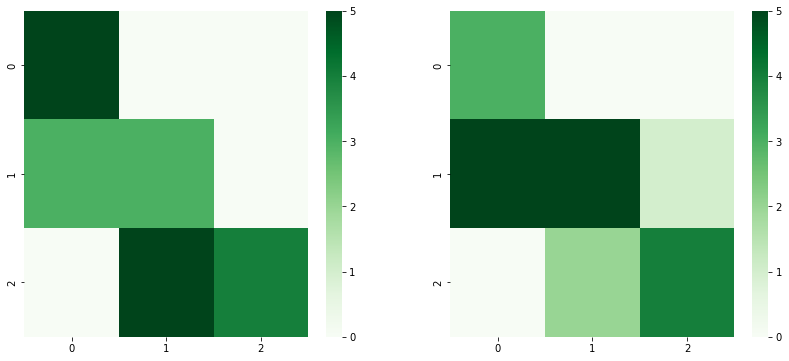

In [53]:
#creo un classificatore Random Forest
rfc = RandomForestClassifier(oob_score=True, criterion='entropy')
#inizializzo un oggetto gridSearch per la ricerca dei migliori parametri
gs_CV = GridSearchCV(estimator=rfc, param_grid=param_grid)
#voglio usare gridsearchCV per ottimizzare gli iperparametri nell'insieme definito da questa griglia
param_grid = {'n_estimators':[100, 200],
                'max_depth':[10,50, 100],
                'max_features':[2,3]}
#per la figura con matrici di confusione
fig, axs = plt.subplots(1, 2, figsize=(14,6) ) 
#imposto il numero di features che voglio usare. Max=4
Nfeatures = 3
timeRanges= ['day', 'evening']
for ii in range(2):
    gs_CV.fit(Xtrain[ii], np.ravel(ytrain[ii]) )
    ypredtest = gs_CV.best_estimator_.predict(Xtest[ii])
    cmat = confusion_matrix( ypredtest, ytest[ii])
    sns.heatmap(cmat, cmap=plt.cm.Greens, ax=axs[ii])
    print(timeRanges[ii]) 
    print(f"Score on test set: {gs_CV.score(Xtest[ii], ytest[ii])}")
    
dump(gs_CV.best_estimator_, "bestRF.joblib")


# Training di una rete neurale feed forward

Proviamo ad utilizzare il MLPClassifier di Scikitlearn per la classificazione dei dati.

/home/gianmarco/anaconda3/envs/DS_2022/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/gianmarco/anaconda3/envs/DS_2022/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


['NeuralNetClassifier.joblib']

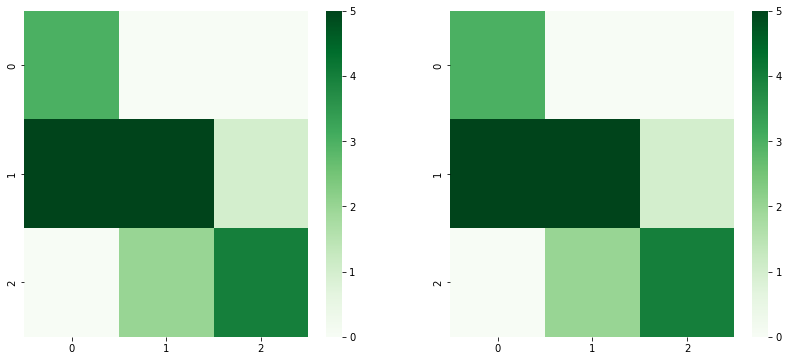

In [59]:
NNW = MLPClassifier(hidden_layer_sizes=(16,16), solver='sgd' ) 
#creo figura per le confusion matrix
figMLP, axsMLP = plt.subplots(1, 2, figsize=(14,6) ) 

for ii in range(2):
    NNW.fit(Xtrain[ii], ytrain[ii])
    y_prediction = NNW.predict(Xtest[ii]) 
    cmatrix = confusion_matrix(y_prediction, ytest[ii]) 
    sns.heatmap(cmat, cmap=plt.cm.Greens, ax=axsMLP[ii])

dump(NNW, "NeuralNetClassifier.joblib")

### dividamo il comune di trento in zone

In [ ]:
grid['geometry'] = grid['geometry'].apply(lambda x:Polygon(x['coordinates'][0]))
grid.crs = from_epsg(code=4326)


In [383]:
gdf_consumi_lordi.to_crs(epsg=4326, inplace=True)
gdf_comuniTN.to_crs(epsg=4326, inplace=True)t on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp_tomerge['date'] =d
comuneTrento = gdf_comuniTN[ gdf_comuniTN['COMUNE'] == 'Trento' ]


<AxesSubplot:>

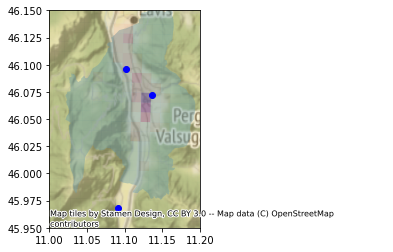

In [391]:

#ax1 = plt.axes()
ax1 = comuneTrento.plot(alpha=0.4)
#grid.plot( ax=ax1, color='red', alpha=0.3)
gdf_consumi_lordi.plot('consumo_per_cella', ax=ax1, alpha=0.3, cmap='YlOrRd') 
cx.add_basemap(ax1 , crs='EPSG:4326') 

ax1.set_xlim(11.0, 11.2)
ax1.set_ylim(45.95, 46.15)

df_mappa_stazioni.plot(ax=ax1 , color='blue') 

Si vuole ottenere un dataframe dove le colonne sono:
label giorno X, zona, meteo relativo alla zona giorni x, x+1, data e fascia oraria, labelconsumi giorno SUCCESSIVO (stessa fascia oraria)

1. Dividere celle in due zone
2. ripescare i consumi riferiti a quelle due zone ed elaborarli in maniera da avere il consumo per ubicazione delle due zone, in realtà per la zona A è tutto fatto perchè è lo stesso database utilizzato per la regressione 
3. aggiungere le stazioni meteo, basterà farlo solo con il database della zona più a Nord perchè per il resto è fatto e poi si deve dividere per fasce orarie, si fa una specie di merge dei database sulla stessa data e voilà il database è servito 

## Cose che rimangono da fare (21 giugno) 

1. Classificazione 

    + capire come migliorare il classificatore Random Forest: bisogna leggere Metha et al e capire come funzione una RF
    + vogliamo includere la fascia oraria nelle features oppure creaimo modelli separati per giorno e  sera?
    + capire se è il caso di farlo per zone (che senso può avere? .... non ne ha...??.)
    + Una volta trovata una buona RF plottare visualizzazioni: matrice di confusione ed eventualmente altro? Cosa?
    
42. Regressione
    
    * regressione provincia trento : creare DF con colonna di consumi complessivi e una colonna per ogni coppia (stazionemeteo, quantitàmisurata) e anche una colonna per ogni coppia (stazioneInquinamento, inquinante). Allenare un regressore.
    * analisi zona trento: abbiamo già il dataset con i consumi, il meteo, e le inquinanti. Basta studiare i regressori e capire come fare un buon regressore. Analisi dei risultati. Idealmente: si potrebbe vedere come variano E_in ed E_out al variare della complessità del modello utilizzate.
    

7. Ulteriori miglioramenti

    * suddividere il codice utilizzando un file make. Le parti in cui dividere il codice dovrebbero essere (file .py)
    
        1. Riordinamento di tabelle (dati interim), "build_features"
        2. Preprocessing
        3. Training dei modelli
        4. Predizione
        5. Visualizzazione dei risultati
        
   * organizzare la repo: metterci i modelli imparati nella cartella models, scrivere una mini(?) relazione in latex dove si riassume ciò che abbiamo fatto . Se avanza tempo. 

## Tentativo di sistemare i dati per la regressione 

In [31]:
# i dati da cui parto sono i dati dei consumi orari per l'intera provincia 
# questo database non è un brutto punto di partenza, ora però aggiungere i dati dell'inquinamento che mancano 
df_meteo_consumi
# dobbiamo sistemare il database df_inquinamento in modo da avere tutte le features più ampie possibili 
df_inquinamentoprov = df_inquinamento.copy()
df_inquinamentoprov['Ora'] = df_inquinamentoprov['Ora'].apply( lambda x: f"{x-1:02d}:00" ) 
df_inquinamentoprov['datetime'] = pd.to_datetime( df_inquinamentoprov['Data']+ df_inquinamentoprov['Ora'],format='%Y-%m-%d%H:%M' )
df_inquinamentoprov = df_inquinamentoprov.drop(columns=['Data','Ora'])
#separo le colonne di diversi inquinanti riferiti a stazioni diverse
df_inquinamentoprov =  df_inquinamentoprov.pivot(index=[ 'Unità di misura', 'datetime'], columns=['Stazione','Inquinante'], values='Valore').reset_index()
#riduco a un solo livello di nomi colonne
df_inquinamentoprov.columns=[' '.join(col).strip() for col in df_inquinamentoprov.columns.values]
#divido in fasce orarie
df_inquinamentoprov=categorizza_tempo(df_inquinamentoprov)
# anche qui sistemo il database in modo da non avere n.d. e trasformarlo in Nan attraverso la funzione aggiusta float 
columns_inquinanti_tot = df_inquinamentoprov.columns[2:18]

In [32]:
for c in columns_inquinanti_tot:

    df_inquinamentoprov[c] = df_inquinamentoprov[c].apply(aggiusta_float)
# anche qui facciamo la media sulle fasce orarie 
df_inquinamentoprov = df_inquinamentoprov.groupby([df_inquinamentoprov['datetime'].dt.date,
                     'Unità di misura', 'TimeRange','isWeekend'])[columns_inquinanti_tot].mean().reset_index()

df_inquinamentoprov.rename(columns={'datetime':'date'}, inplace=True)

In [33]:
df_meteo_consumi_tot = df_meteo_consumi.copy()
# voglio solo i dati infrasettimanali 
df_meteo_consumi_tot = df_meteo_consumi_tot[~df_meteo_consumi_tot['isWeekend']]
# voglio ora però i consumi totali di fatto dell'intera provincia di trento 
df_meteo_consumi_tot.drop(['station', 'elevation'], inplace = True, axis = 1)
# ora cercherò di eseguire un groupby 
## df_ubi_per_line = pd.DataFrame(df_linee.groupby('LINESET')['NR_UBICAZIONI'].sum()).reset_index()
colonnedaraggruppare = ['consumoTerritorio', 'meanTemperature','precipitations', 'meanWinds', 'NR_UBICAZIONI','consumoOrarioUbicazione']
#prova = pd.DataFrame(df_meteo_consumi_tot.groupby(['date', 'TimeRange', 'isWeekend'])[colonnedaraggruppare].mean()).reset_index()
# per sicurezza lo faccio anche su df_inquinamentoprov
df_inquinamentoprov = df_inquinamentoprov[~df_inquinamentoprov['isWeekend']]
df_inquinamentoprov = df_inquinamentoprov.groupby( ['date', 'TimeRange', 'isWeekend']).agg(np.nanmean).reset_index()


In [34]:
# in questa cella ho cercato di fare un groupby sui consumi delle tre fasce orarie e sono riuscita
# a dirgli quali colonne sommare e quali invece mediare, purtroppo non riesco a dirglielo in maniera più elegante di così
# è un po' grezzo, ma in qualche modo funziona 
#df = df.groupby(['Symbol']).agg({'Profit': ['sum'], 'Volume': ['sum'], 'Commission': ['sum'], 'Time': pd.Series.mode})
colonnedamediare = tuple(['meanTemperature','precipitations','meanWinds', 'consumoOrarioUbicazione'])
df_meteo_consumi_tot= pd.DataFrame(df_meteo_consumi_tot.groupby(['date', 'TimeRange', 'isWeekend']).agg({'consumoTerritorio' : ['sum'],'NR_UBICAZIONI' : ['sum'] ,'meanTemperature': ['mean'], 'precipitations' : ['mean'], 'meanWinds': ['mean'], 'consumoOrarioUbicazione': ['mean']}))

In [35]:
# tolgo il multindice dalle colonne 
df_meteo_consumi_tot.columns = list(map(''.join, df_meteo_consumi_tot.columns.values))
# resetto l'indice 
df_meteo_consumi_tot = df_meteo_consumi_tot.reset_index()
# ora dovrei essere pronta a fare un merge con il database dell'inquinamento 
df_meteo_consumi_inq_tot = pd.merge( left=df_inquinamentoprov, right=df_meteo_consumi_tot, on=['TimeRange', 'isWeekend', 'date'])




In [36]:
df_meteo_consumi_inq_tot

,date,TimeRange,isWeekend,Parco S. Chiara PM10,Parco S. Chiara PM2.5,Parco S. Chiara Biossido di Azoto,Parco S. Chiara Ozono,Parco S. Chiara Biossido Zolfo,Via Bolzano PM10,Via Bolzano Biossido di Azoto,...,Borgo Valsugana PM10,Borgo Valsugana PM2.5,Borgo Valsugana Biossido di Azoto,Borgo Valsugana Ozono,consumoTerritoriosum,NR_UBICAZIONIsum,meanTemperaturemean,precipitationsmean,meanWindsmean,consumoOrarioUbicazionemean
0,2013-11-01,day,False,25.181818,16.636364,30.545455,7.909091,1.181818,28.272727,32.818182,...,27.818182,8.727273,19.181818,10.636364,292081.262027,138743,11.837184,0.005556,1.189619,0.091128
1,2013-11-01,evening,False,45.400000,29.200000,42.000000,5.000000,0.800000,55.800000,53.800000,...,30.400000,16.600000,20.000000,7.600000,146824.968450,138743,10.256937,0.005556,0.926591,0.142114
2,2013-11-01,night,False,22.250000,13.500000,33.500000,2.000000,1.500000,31.000000,35.500000,...,19.875000,12.375000,17.500000,2.000000,189975.538000,138743,9.253646,0.000000,0.762840,0.053167
3,2013-11-04,day,False,8.909091,6.363636,40.125000,4.900000,1.750000,12.454545,53.555556,...,15.545455,7.636364,31.181818,7.727273,492895.718458,138743,7.300253,3.500000,0.917144,0.324866
4,2013-11-04,evening,False,11.200000,8.600000,40.200000,1.000000,1.200000,12.800000,45.000000,...,26.800000,19.000000,29.600000,3.600000,181140.198258,138743,6.730658,0.705556,0.966654,0.274877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,2013-12-30,evening,False,27.600000,24.400000,65.400000,4.600000,2.600000,39.600000,72.200000,...,35.400000,24.800000,41.400000,3.800000,231700.737912,138743,-1.544028,0.000000,1.087076,0.548194
125,2013-12-30,night,False,5.500000,4.500000,30.750000,23.125000,0.250000,6.125000,26.375000,...,20.125000,13.625000,25.250000,2.000000,242358.892829,138743,0.252951,0.005556,1.693075,0.262528
126,2013-12-31,day,False,12.636364,10.545455,46.818182,21.000000,1.636364,19.545455,57.454545,...,22.909091,16.545455,47.272727,14.636364,500806.439907,138743,-0.114788,0.000000,1.142190,0.496384
127,2013-12-31,evening,False,29.600000,27.600000,62.400000,5.600000,2.400000,43.000000,74.000000,...,44.000000,25.000000,43.000000,4.600000,221956.073320,138743,-2.754102,0.000000,1.203595,0.546593


In [425]:
df_giornoTN = df_meteo_consumi_inq_tot[ df_meteo_consumi_inq_tot['TimeRange'] == 'day' ].reset_index().drop(columns='index')
df_seraTN = df_meteo_consumi_inq_tot[ df_meteo_consumi_inq_tot['TimeRange'] == 'evening' ].reset_index().drop(columns='index')

columns_to_drop = ['date_x', 'date_x+1' , 'TimeRange_x', 'isWeekend_x', 'consumoTerritoriosum_x', 'NR_UBICAZIONIsum_x', 'dayOfWeek_x',
                      'TimeRange_x+1', 'isWeekend_x+1', 'consumoTerritoriosum_x+1', 'NR_UBICAZIONIsum_x+1', 'dayOfWeek_x+1']


df_giornoTN = addNextDay(df_giornoTN, columns_to_drop)
df_seraTN = addNextDay(df_seraTN, columns_to_drop)

print(df_giornoTN.columns.values)
print(df_seraTN.columns.values)

DEBUG
date                         2013-11-01
TimeRange                           day
isWeekend                         False
(A) PM10                      25.181818
(A) PM2.5                     16.636364
(A) Biossido di Azoto         30.545455
(A) Ozono                      7.909091
(A) Biossido Zolfo             1.181818
(B) PM10                      28.272727
(B) Biossido di Azoto         32.818182
(B) Ossido di Carbonio         0.581818
(C) PM10                      29.545455
(C) PM2.5                     20.454545
(C) Biossido di Azoto         27.090909
(C) Ozono                          19.0
(D) PM10                      27.818182
(D) PM2.5                      8.727273
(D) Biossido di Azoto         19.181818
(D) Ozono                     10.636364
consumoTerritoriosum      292081.262027
NR_UBICAZIONIsum                 138743
T media                       11.837184
Precipitazioni                 0.005556
Vento                          1.189619
consumo                        0.0

In [291]:
#divido il database in train e test
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
#queste due righe se commentate permettono tutte le possibili coppie di giorni, se eseguite solo coppie distinte 
df_giornoTN = df_giornoTN.loc[rowsToKeep,:]
df_seraTN = df_seraTN.loc[rowsToKeep,:]

def regressioneLineare( df_in, feat, targ, talk=False ) : 

    Xtrain, Xtest, Ytrain, Ytest = train_test_split(df_in[feat], df_in[targ], test_size = 0.30, random_state = 7)
    #adesso scalo i dati con lo standard scaler
    ppl = Pipeline(  [ ('scaler', StandardScaler() ) , ('clf', LinearRegression() ) ] ) 
    ppl.fit(Xtrain, Ytrain) 
    #Ypred = ppl.predict(Xtest)
    trainScore= ppl.score(Xtrain, Ytrain)
    testScore = ppl.score(Xtest, Ytest)
    if talk:
        print(f"score on train is = {trainScore}")
        print(f"score on test is = {testScore}")
    return (trainScore, testScore)

#ora le features sono tutte le colonne tranne l'ultima, che è il target
features= ['consumoOrarioUbicazionemean_x', 'meanTemperaturemean_x', 'Parco S. Chiara Biossido Zolfo_x']
target =  'consumoOrarioUbicazionemean_x+1'
#target = df_giornoTN.columns.values[-1]]
regressioneLineare(df_giornoTN, features, target)
regressioneLineare(df_seraTN, features, target)
    

(0.9557301160934866, 0.9232802487383748)

[[1.         0.07137935]
 [0.07137935 1.        ]]


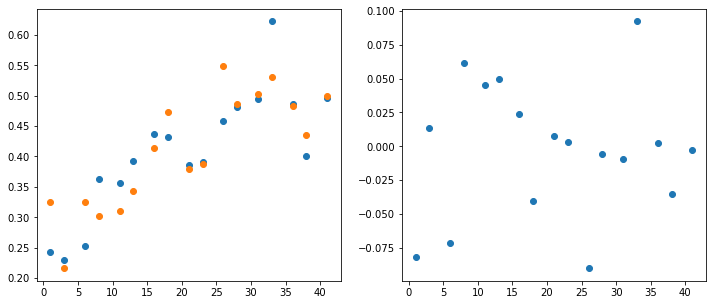

In [209]:
fig, axs = plt.subplots(1, 2, figsize=(12,5)) 
ap1 = df_giornoTN['consumoOrarioUbicazionemean_x+1' ]
a =  df_giornoTN['consumoOrarioUbicazionemean_x' ] 
x = df_giornoTN.index.values
axs[0].scatter( x, ap1 ) 
axs[0].scatter( x, a ) 
axs[1].scatter( x, ap1-a ) 
covmat = np.corrcoef(x, ap1-a)


score on train is = 0.7831008581921075
score on test is = 0.6712701723763181


In [105]:
#metto a fianco i due dataframes
df_giorno_x_xp1 = pd.merge(left = df_giornoTN, right= df_giornoTN_xp1, on=

,date,TimeRange,isWeekend,Parco S. Chiara PM10,Parco S. Chiara PM2.5,Parco S. Chiara Biossido di Azoto,Parco S. Chiara Ozono,Parco S. Chiara Biossido Zolfo,Via Bolzano PM10,Via Bolzano Biossido di Azoto,...,Borgo Valsugana PM2.5,Borgo Valsugana Biossido di Azoto,Borgo Valsugana Ozono,consumoTerritoriosum,NR_UBICAZIONIsum,meanTemperaturemean,precipitationsmean,meanWindsmean,consumoOrarioUbicazionemean,dayOfWeek
0,2013-11-01,day,False,25.181818,16.636364,30.545455,7.909091,1.181818,28.272727,32.818182,...,8.727273,19.181818,10.636364,292081.262027,138743,11.837184,0.005556,1.189619,0.091128,4
1,2013-11-04,day,False,8.909091,6.363636,40.125000,4.900000,1.750000,12.454545,53.555556,...,7.636364,31.181818,7.727273,492895.718458,138743,7.300253,3.500000,0.917144,0.324866,0
2,2013-11-05,day,False,10.363636,7.272727,35.545455,8.545455,1.909091,18.181818,48.090909,...,7.909091,23.272727,14.727273,455374.880566,138743,9.795228,0.061111,1.190831,0.243301,1
3,2013-11-06,day,False,8.272727,5.272727,31.090909,25.181818,1.363636,7.181818,36.181818,...,5.090909,26.818182,27.363636,460321.190708,138743,10.472108,0.194444,1.918532,0.215749,2
4,2013-11-07,day,False,15.272727,9.545455,39.363636,7.272727,2.727273,26.272727,51.181818,...,18.363636,29.272727,13.818182,453392.307536,138743,10.485358,0.000000,1.283330,0.229080,3
5,2013-11-08,day,False,20.727273,13.545455,33.818182,1.818182,3.818182,28.272727,45.909091,...,23.272727,29.636364,5.090909,489172.850505,138743,9.901894,0.200000,1.129356,0.328528,4
6,2013-11-11,day,False,3.000000,2.000000,9.727273,73.454545,0.000000,2.636364,8.272727,...,2.500000,20.000000,58.181818,486685.277024,138743,8.884533,0.111111,4.143002,0.324296,0
7,2013-11-12,day,False,20.750000,9.400000,49.090909,20.000000,2.454545,21.000000,56.727273,...,26.500000,42.444444,20.200000,442452.540468,138743,9.264300,0.116667,1.191379,0.253047,1
8,2013-11-13,day,False,21.363636,14.272727,49.818182,5.727273,3.727273,33.272727,78.363636,...,18.750000,41.545455,9.090909,471289.447020,138743,10.301214,0.022222,0.969692,0.301335,2
9,2013-11-14,day,False,20.363636,14.909091,46.000000,2.181818,3.636364,34.454545,72.545455,...,23.200000,32.181818,4.727273,499685.480466,138743,7.398169,2.700000,0.905555,0.362929,3


# Cose che rimangono da fare (16 luglio) 

1. regressione per i dati serali ( volendo, si potrebbe far vedere come variano gli score all'aumentare delle features incluse ) 
2. classificazione: aggiustare il df con i dati giorno x - x+1 (usare quello già usato per regressione e categorizzarlo). farla sia per giorno che per la notte. 
3. dividere il comune di trento in due zone (nord/sud) . NECESSARIO CAPIRE COSA DIAMINE CE NE DOBBIAMO FARE DI QUESTE ZONE.
4. 


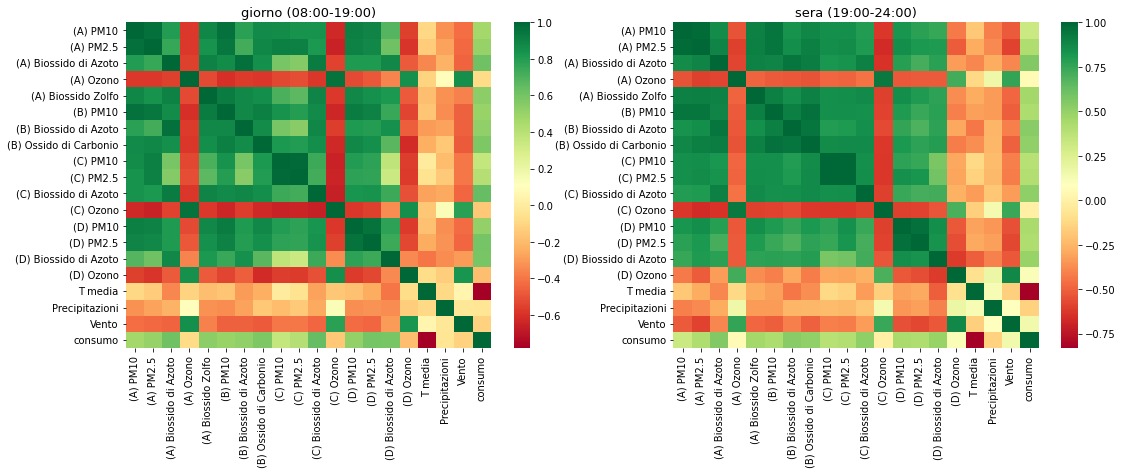

In [267]:
columnNames = ['(A) PM10',
       '(A) PM2.5', '(A) Biossido di Azoto',
       '(A) Ozono', '(A) Biossido Zolfo',
       '(B) PM10', '(B) Biossido di Azoto',
       '(B) Ossido di Carbonio', '(C) PM10',
       '(C) PM2.5', '(C) Biossido di Azoto', '(C) Ozono',
       '(D) PM10', '(D) PM2.5',
       '(D) Biossido di Azoto', '(D) Ozono', 'T media',
       'Precipitazioni', 'Vento',
       'consumo']
       
OriginalcolumnNames = ['Parco S. Chiara PM10',
       'Parco S. Chiara PM2.5', 'Parco S. Chiara Biossido di Azoto',
       'Parco S. Chiara Ozono', 'Parco S. Chiara Biossido Zolfo',
       'Via Bolzano PM10', 'Via Bolzano Biossido di Azoto',
       'Via Bolzano Ossido di Carbonio', 'Rovereto PM10',
       'Rovereto PM2.5', 'Rovereto Biossido di Azoto', 'Rovereto Ozono',
       'Borgo Valsugana PM10', 'Borgo Valsugana PM2.5',
       'Borgo Valsugana Biossido di Azoto', 'Borgo Valsugana Ozono', 'meanTemperaturemean',
       'precipitationsmean', 'meanWindsmean',
       'consumoOrarioUbicazionemean']
       
dictnomicolonne = dict(zip(OriginalcolumnNames,columnNames) ) 
df_meteo_consumi_inq_tot.rename(columns = dictnomicolonne, inplace=True)
figmat, axs_corr_mat = plt.subplots(1,2, figsize=(18,6))

dfFasceOrarie = [df_meteo_consumi_inq_tot[df_meteo_consumi_inq_tot['TimeRange'] == 'day'], 
                 df_meteo_consumi_inq_tot[df_meteo_consumi_inq_tot['TimeRange'] == 'evening'] ]
for ii in range(2):
    corr = dfFasceOrarie[ii][columnNames].corr()
    sns.heatmap(corr, ax=axs_corr_mat[ii], cmap=plt.cm.RdYlGn)# annot=True)
    axs_corr_mat[ii].set_title( fasce[ii] , fontsize=13)


In [277]:
#sistemo il database dell'intera provincia di Trento per effettuare la regressione in modo analogo a quello del comune di Trento
dfgiornoProv = df_meteo_consumi_inq_tot[df_meteo_consumi_inq_tot['TimeRange'] == 'day'].reset_index().drop(columns = 'index')
dfgiornoProv = addNextDay(dfgiornoProv)
dfseraProv = df_meteo_consumi_inq_tot[df_meteo_consumi_inq_tot['TimeRange'] == 'evening'].reset_index().drop(columns = 'index')
dfseraProv = addNextDay(dfseraProv)

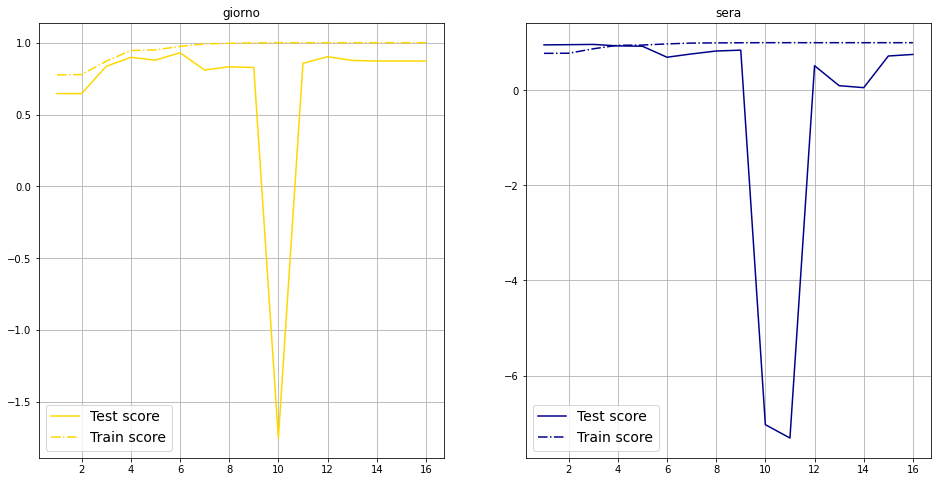

In [298]:
featuresList = ['consumo_x', 'T media_x','T media_x+1', '(A) Biossido Zolfo_x', 'Vento_x', 'Precipitazioni_x', 
                '(A) Biossido di Azoto_x', '(B) Biossido di Azoto_x', '(C) Biossido di Azoto_x',
                 '(A) Biossido Zolfo_x+1', 'Vento_x+1', 'Precipitazioni_x+1', 
                '(A) Biossido di Azoto_x+1', '(B) Biossido di Azoto_x+1', '(C) Biossido di Azoto_x+1',
                '(D) Biossido di Azoto_x+1']
#'(D) Biossido di Azoto_x', 'T media_x+1',
N = len(featuresList) 
ygTest = np.zeros( (N,)  ) 
ysTrain = np.zeros( (N,)  )
ygTrain = np.zeros( (N )  )
ysTest = np.zeros( (N,)  )
Nfeatures = np.zeros( (N) ) 
target =  'consumo_x+1'
#queste due righe se commentate permettono tutte le possibili coppie di giorni, se eseguite solo coppie distinte 
dfgiornoProv = dfgiornoProv.loc[rowsToKeep,:]
dfseraProv = dfseraProv.loc[rowsToKeep,:]
for jj, feats in enumerate(featuresList):
    Nfeatures[jj] = jj+1
    ygTrain[jj], ygTest[jj] = regressioneLineare(dfgiornoProv, featuresList[0:jj+1], target)
    ysTrain[jj], ysTest[jj] = regressioneLineare(dfseraProv, featuresList[0:jj+1], target)

fig, axs = plt.subplots(1, 2, figsize=(16,8) )
colors = ['gold', 'darkblue']
testscore  = [ygTest, ysTest]
trainscore = [ygTrain, ygTrain]
titles = ['giorno', 'sera']
for ii  in range(2):
    axs[ii].plot( Nfeatures, testscore[ii], label='Test score', color=colors[ii])
    axs[ii].plot( Nfeatures, trainscore[ii], label='Train score', color=colors[ii], linestyle='-.')
    axs[ii].legend(fontsize=14)
    axs[ii].grid(visible=True)
    axs[ii].set_title( titles[ii] ) 


    

In [286]:
dfgiornoProv.columns.values

array(['(A) PM10_x', '(A) PM2.5_x', '(A) Biossido di Azoto_x',
       '(A) Ozono_x', '(A) Biossido Zolfo_x', '(B) PM10_x',
       '(B) Biossido di Azoto_x', '(B) Ossido di Carbonio_x',
       '(C) PM10_x', '(C) PM2.5_x', '(C) Biossido di Azoto_x',
       '(C) Ozono_x', '(D) PM10_x', '(D) PM2.5_x',
       '(D) Biossido di Azoto_x', '(D) Ozono_x', 'T media_x',
       'Precipitazioni_x', 'Vento_x', 'consumo_x', '(A) PM10_x+1',
       '(A) PM2.5_x+1', '(A) Biossido di Azoto_x+1', '(A) Ozono_x+1',
       '(A) Biossido Zolfo_x+1', '(B) PM10_x+1',
       '(B) Biossido di Azoto_x+1', '(B) Ossido di Carbonio_x+1',
       '(C) PM10_x+1', '(C) PM2.5_x+1', '(C) Biossido di Azoto_x+1',
       '(C) Ozono_x+1', '(D) PM10_x+1', '(D) PM2.5_x+1',
       '(D) Biossido di Azoto_x+1', '(D) Ozono_x+1', 'T media_x+1',
       'Precipitazioni_x+1', 'Vento_x+1', 'consumo_x+1'], dtype=object)